In [1]:
%matplotlib inline
import random as r
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import scipy
import scipy.stats as st
from sklearn.preprocessing import normalize, scale
import pandas as pd

In [15]:
'''4e: Factoring In Past Transactions
Alpha is from 1.0 to 2.0
Gamma is from 0.0 to 4.0'''

def trade(m_i,m_j):
    '''
    epsilon is a percentage of change, [0,1] occurring between each trade.
    m_i and m_j are participating agents stored as a float representing their wealth.
    returns m_i_prime and m_j_prime, the wealth of each agent post-transaction
    '''
    epsilon = r.uniform(0,1)
    m_i_prime = epsilon*(m_i+m_j)
    m_j_prime = (1-epsilon)*(m_i+m_j)

    #ensure that nobody has negative wealth value post-transaction
    while m_i_prime < 0 or m_j_prime < 0:
        epsilon = r.uniform(0,1)
        m_i_prime = epsilon*(m_i+m_j)
        m_j_prime = (1-epsilon)*(m_i+m_j)
        
    delta_m = epsilon*m_j

    return m_i_prime, m_j_prime
def iterate_nearest_neighbor_past_transactions(n_transactions, agent_list, a, gamma, ledger):
    '''
    n_transactions = number of transactions for each cycle
    agent_list = initial 'pool' of agents, each with a specified starting wealth
    n_agents = number of agents in each list
    function sequence: 
    choose 2 agents with nonzero wealth to trade -> 
    denote c as number of transactions between 2 agents ->
    
    transfer wealth -> 
    update wealth -> 
    repeat for n_transactions
    '''
    n_agents = len(agent_list)
    agent_set = set(np.arange(0,n_agents))
    for t in range(n_transactions):
        #choose agents
        i1, i2 = r.sample(agent_set,2)
        agent1, agent2 = agents[i1], agents[i2]
        c = ledger[i1][i2]
        #verify if transaction is feasible by finding compatible agents
        while valid_transaction(agent1,agent2,a,c,gamma) == False:
            #keep finding compatible agents until transaction conditions are met
            i1, i2 = r.sample(agent_set,2)
            agent1, agent2 = agent_list[i1], agent_list[i2]
            c = ledger[i1][i2]
            
        #trade with agents once we find compatible agents
        agent_list[i1], agent_list[i2] = trade(agent1,agent2)
        ledger[i1][i2] += 1
    return agent_list
        
def valid_transaction(agent1, agent2, a, c, gamma):
    if agent1 <= 0 or agent2 <= 0:
        return False
    try:
        roll = r.uniform(0,1)
        p = ((abs(agent2-agent1))**(-a))*(c+1)**(gamma)
        return roll <= p
    except ZeroDivisionError:
        return False
    
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [        
            st.norm,st.pareto
    ]


    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        #try:
            # Ignore warnings from data that can't be fit
            #with warnings.catch_warnings():
                #warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data,loc=1,scale=1)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        #except Exception:
            #print("Exception")
            #pass

    return (best_distribution.name, best_params)

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf
    
alpha_lst = np.arange(0.5,2.0,1.5)
gamma_lst = np.arange(0.0,4.0,1.0)
n_agents = 500
transactions = 10**4
money = 1.0
wealth_distribution_rows = []
for a in alpha_lst:
    for g in gamma_lst:
        agents = np.full(n_agents,money)
        ledger = np.zeros((n_agents,n_agents))
        wealth_distribution = iterate_nearest_neighbor_past_transactions(transactions, agents, a, g, ledger)            
        wealth_distribution = scale(wealth_distribution,with_mean = True, with_std = True)
        best_fit_name, best_fit_params = best_fit_distribution(wealth_distribution, 50)
        best_dist = getattr(st, best_fit_name)
        wealth_distribution_rows.append([a,g,best_fit_name,best_fit_params])

wd_ag_df = pd.DataFrame(wealth_distribution_rows,columns=['alpha','gamma','distribution','parameters'])
wd_ag_df.to_csv('wealth_distributions_ag2.csv')



In [16]:
wd_ag_df

,alpha,gamma,distribution,parameters
0,0.5,0,norm,"(6.03961325396e-17, 1.0)"
1,0.5,1,norm,"(1.06581410364e-17, 1.0)"
2,0.5,2,pareto,"(3.15899351339, -2.65989720267, 1.84537330374)"
3,0.5,3,norm,"(3.01980662698e-17, 1.0)"


In [4]:
def iterate_with_savings(n_transactions, agent_list, l):

        
    n_agents = len(agent_list)
    agent_set = set(np.arange(0,n_agents))
    for t in range(n_transactions):
        i1, i2 = r.sample(agent_set,2)
        agent1, agent2 = agent_list[i1], agent_list[i2]
        #ensure transactions between nonzero wealth
        while agent1 < 0 or agent2 < 0:
            i1, i2 = r.sample(agent_set,2)
            agent1, agent2 = agent_list[i1], agent_list[i2]
        agent1_prime, agent2_prime = trade_with_savings(agent1, agent2, l)

        agent_list[i1], agent_list[i2] = agent1_prime, agent2_prime
    return agent_list

        
def trade_with_savings(m_i,m_j,l):
    m_i_prime = -1
    m_j_prime = -1

    while m_i_prime < 0 or m_j_prime < 0:
        epsilon = r.uniform(0,1)
        m_i_prime = l*m_i + epsilon*(1-l)*(m_i+m_j)
        m_j_prime = l*m_j + (1-epsilon)*(1-l)*(m_i+m_j)
        

    return m_i_prime, m_j_prime

'''Trials for varying lambda'''

agent_no = 500
transactions = 10**6
money = 1.0
beta = 1/money
m_0 = money*agent_no
lambda_lst = np.linspace(0,0.95,20)
wealth_distribution_rows_lambda = []

for l in lambda_lst:
    agents = np.full(agent_no,money)
    wealth_distribution = iterate_with_savings(transactions, agents, l)
    wealth_distribution = scale(wealth_distribution, with_mean = True, with_std = True)
    best_fit_name, best_fit_params = best_fit_distribution(wealth_distribution, 50)
    best_dist = getattr(st, best_fit_name)
    wealth_distribution_rows_lambda.append([l,best_fit_name,best_fit_params])

wd_l_df = pd.DataFrame(wealth_distribution_rows_lambda,index=lambda_lst,columns=['lambda','distribution','params'])

In [5]:
wd_l_df

,lambda,distribution,params
0.00,0.00,pareto,"(1.44083332111, -1.78016921171, 0.82014583234)"
0.05,0.05,pareto,"(1.22524889947, -1.86407318016, 0.806999161351)"
0.10,0.10,pareto,"(1.17142263044, -1.81995845025, 0.779284610272)"
0.15,0.15,norm,"(-1.43884903991e-16, 1.0)"
0.20,0.20,norm,"(-1.06581410364e-17, 1.0)"
0.25,0.25,norm,"(3.90798504668e-17, 1.0)"
0.30,0.30,norm,"(-5.68434188608e-17, 1.0)"
0.35,0.35,norm,"(1.24344978758e-17, 1.0)"
0.40,0.40,norm,"(-2.30926389122e-16, 1.0)"
0.45,0.45,norm,"(-2.39808173319e-16, 1.0)"


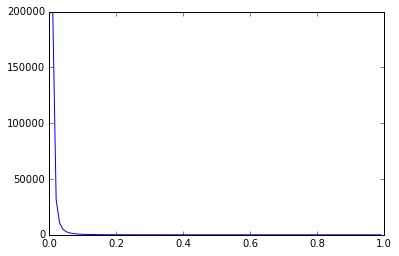

In [12]:
def f(a,b,x):
    return a*x**(-b-1)

x = np.arange(0,1,0.01)
y = f(1.0,1.6489,x)
plt.plot(x,y)